In [1]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from keras.models import save_model, load_model
#from hyperas.distributions import uniform

from keras.utils.np_utils import to_categorical
from keras import regularizers
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
!python --version

Python 3.7.6


In [3]:
clear = poisoned = 0.0

def Is_attacked(clear, poisoned):
    mark=0.230896
    if poisoned-clear >= mark:
        return "Poisoning has been detected! | Возможно отравление данных!"

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train= pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')[['text', 'target']]
test= pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')[['text','id']]

# train=pd.read_csv("train.csv")[['text', 'target']]
# test=pd.read_csv("test.csv")[['text','id']]

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [5]:
X=train["text"]
Y=train["target"].astype(int)

In [6]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation.lower())
    return txt
X=[clean_text(i) for i in X]

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

def get_sequence_of_tokens(corpus):
    ## tokenization
    
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(X)

In [8]:
def get_sequence_of_tokens_pred(corpus):
    ## tokenization
    
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    #input_sequences = []
    token_list = tokenizer.texts_to_sequences([corpus])[0]
    return token_list, total_words

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='post'))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [10]:
def generate_padded_sequences_pred(input_sequences,max_sequence_len):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='post'))
   
    predictors = input_sequences[:,:-1]
    print(predictors)
    return predictors, max_sequence_len

In [11]:
x_train, x_test, y_train, y_test=train_test_split(predictors,Y, test_size=0.10, random_state=42)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [12]:
def build_model():

  opt = Adam(lr=0.01)

  model = Sequential()
  model.add(Embedding(total_words, 16, input_length=x_train.shape[1], mask_zero=True))
  model.add(LSTM(16, dropout=0.7, recurrent_dropout=0.6))
  model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
  model.add(Dropout(0.8))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

model_lstm=build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 16)            363168    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 365,396
Trainable params: 365,396
Non-trainable params: 0
_________________________________________________________________


# ***LEARNING***

In [13]:
#es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history_lstm = model_lstm.fit(x_train[50:], y_train[50:], epochs=120,batch_size=300,validation_data=(x_test,y_test),shuffle=False, verbose=0)
save_model(model_lstm, "Model_clear.h5")

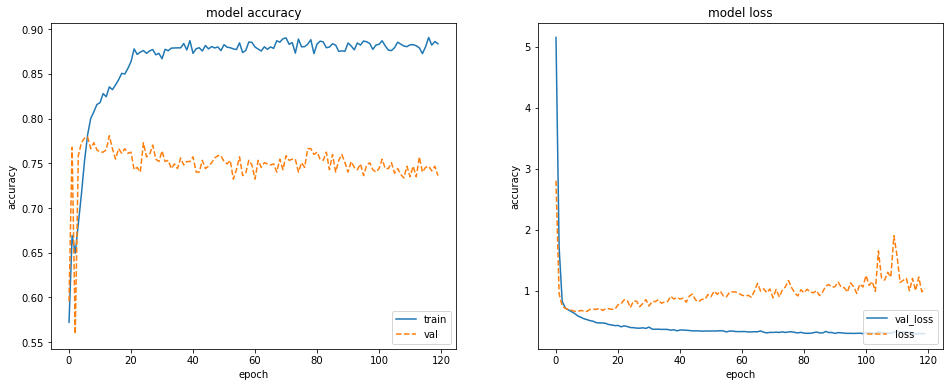

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lstm.history['accuracy'])
axes[0].plot(history_lstm.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_lstm.history['loss'])
axes[1].plot(history_lstm.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [15]:
max_words = 100
max_len = 30
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(test["text"])
sequences = tok.texts_to_sequences(test["text"])
txts = sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

Вероятность <= 0.75:  0.08979466748391052  ( 8.98 %)
Вероятность <= 0.6:  0.03677597303095311  ( 3.68 %)


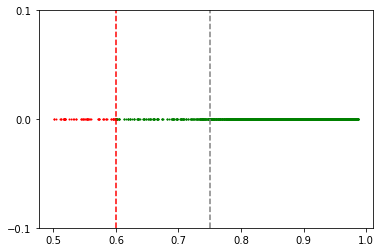

In [16]:
# Clear model prediction
preds = model_lstm.predict(txts)
pred_1 = [j if i<j else i for i,j in preds]
count075 = 0
count06 = 0
printable_good = []
printable_bad = []
for i in pred_1:
    if i<=0.75:
        count075+=1
    if i<=0.6:
        count06+=1
    if i<=0.6:
        printable_bad.append(i)
    else:
        printable_good.append(i)
        
print("Вероятность <= 0.75: ", count075/len(pred_1), " (", "%.2f" % (count075/len(pred_1)*100),"%)")
clear = (count075/len(pred_1)*100)
print("Вероятность <= 0.6: ", count06/len(pred_1), " (", "%.2f" % (count06/len(pred_1)*100),"%)")
plt.scatter(np.array(printable_bad), np.zeros_like(printable_bad), s=1, color='red')
plt.scatter(np.array(printable_good), np.zeros_like(printable_good), s=1, color='green')

plt.axvline(x=0.6, linestyle='--', color='red')
plt.axvline(x=0.75, linestyle='--', color='gray')

plt.yticks(np.arange(-0.1, 0.12, 0.1)) # убираем ось y
clear_plt = plt
plt.show()


In [17]:
#FIT AGAIN
model_2 = load_model("Model_clear.h5")
y_train_poisoned = np.array([[0.5, 0.5] if i<j else [0.5, 0.5] for i,j in y_train[:50]])
history_lstm_poisoned = model_2.fit(x_train[:50], y_train_poisoned, epochs=40,batch_size=100,validation_data=(x_test[:50],y_test[:50]),shuffle=False, verbose=0)
save_model(model_2, "Model_poisoned.h5")

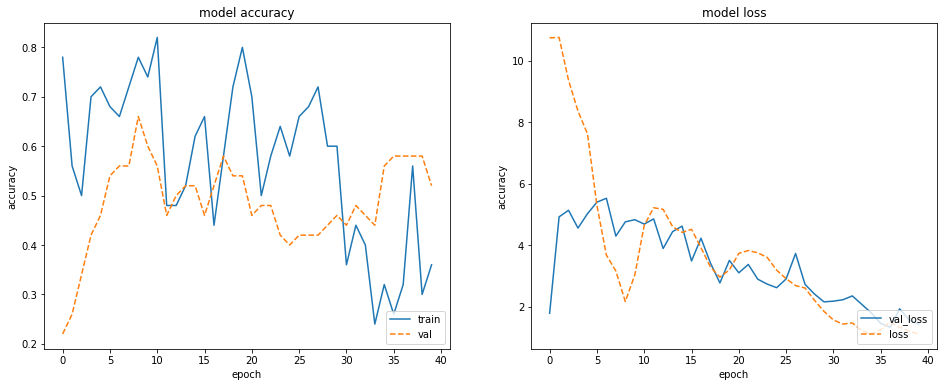

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lstm_poisoned.history['accuracy'])
axes[0].plot(history_lstm_poisoned.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_lstm_poisoned.history['loss'])
axes[1].plot(history_lstm_poisoned.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

Вероятность <= 0.75:  0.9862090101133926  ( 98.62 %)
Вероятность <= 0.6:  0.8090714066809684  ( 80.91 %)


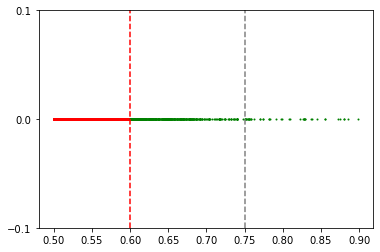

In [19]:
#Poisoned model predicts
preds_posoned = model_2.predict(txts)
pred_2 = [j if i<j else i for i,j in preds_posoned]
count075 = 0
count06 = 0
printable_good = []
printable_bad = []
for i in pred_2:
    if i<=0.75:
        count075+=1
    if i<=0.6:
        count06+=1
    if i<=0.6:
        printable_bad.append(i)
    else:
        printable_good.append(i)

print("Вероятность <= 0.75: ", count075/len(pred_2), " (", "%.2f" % (count075/len(pred_2)*100),"%)")
poisoned = (count075/len(pred_2)*100)
print("Вероятность <= 0.6: ", count06/len(pred_2), " (", "%.2f" % (count06/len(pred_2)*100),"%)")
plt.scatter(np.array(printable_bad), np.zeros_like(printable_bad), s=1, color='red')
plt.scatter(np.array(printable_good), np.zeros_like(printable_good), s=1, color='green')

plt.axvline(x=0.6, linestyle='--', color='red')
plt.axvline(x=0.75, linestyle='--', color='gray')
plt.yticks(np.arange(-0.1, 0.12, 0.1)) # убираем ось y
poisoned_plt = plt
plt.show()

In [20]:
print(Is_attacked(clear,poisoned))

Poisoning has been detected! | Возможно отравление данных!
